In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

3607995


In [2]:
library_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune'


In [3]:
target_gene_mean_exp_filename = os.path.join(library_folder, 'selected_gene_mean_exp.csv')
mean_exp_df = pd.read_csv(target_gene_mean_exp_filename).set_index('gene_symbols')
target_gene_umi_frac_filename = os.path.join(library_folder, 'selected_gene_umi_frac.csv')
umi_frac_df = pd.read_csv(target_gene_umi_frac_filename).set_index('gene_symbols')

celltype_num_filename = os.path.join(library_folder, 'celltype_num.csv')
celltype_num = pd.read_csv(celltype_num_filename).set_index('Unnamed: 0')
# 
# The output codebook filename
codebook_file = os.path.join(library_folder, 'codebook.csv')

In [51]:
replace_dict = {'Tcrg-C1':'Trgc1', 'Tcrg-C2':'Trgc2', 'Tcrg-C4':'Trgc4', 'Sept1':'Septin1', 'H2afy':'Macroh2a2','Qk':'Qki'}
mean_exp_df = mean_exp_df.rename(replace_dict)

In [4]:
num_genes = len(mean_exp_df)
print(num_genes)

294


# load codebook

## load covering design

In [8]:
# analysis 
from ChromAn.src.library_tools.design_codebook import barcode_to_matrix, HammingDist_for_matrix, remove_bad_barcodes

In [9]:
covering_folder = '/lab/solexa_weissman/puzheng/References/Encoding_Design'
#covering_folder = r'Y:\References\Encoding_Design' # mapped this folder in Windows

num_bits = 22
hamming_weight = 4
hamming_distance = 4


covering_design_filename = os.path.join(covering_folder, f'covering_v{num_bits}_k{hamming_weight}_t{int(hamming_weight + 1 - (hamming_distance / 2))}.txt')
print(covering_design_filename)
design_df = pd.read_csv(covering_design_filename, header=None, delimiter='\s+')
print(len(design_df))
design_barcodes = design_df.values - 1

design_matrix = barcode_to_matrix(design_barcodes)


/lab/solexa_weissman/puzheng/References/Encoding_Design/covering_v22_k4_t3.txt
385


minimum hamming distance: 4


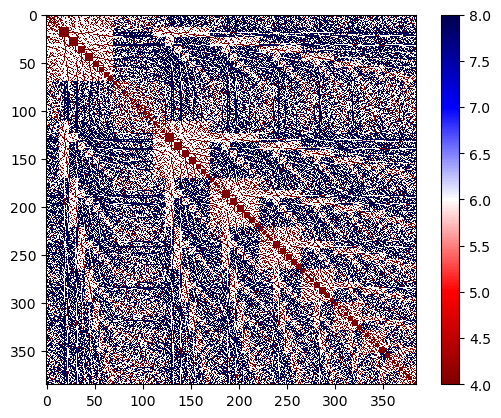

In [33]:
# check hamming distances
distmat = HammingDist_for_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(distmat, cmap='seismic_r', vmin=4, vmax=8, interpolation='nearest')
plt.colorbar()
plt.show()

In [34]:
# reduce map if necessary
reduced_design_barcodes = remove_bad_barcodes(design_barcodes, 
                                              min_hamming_dist=hamming_distance)
code_length = len(np.unique(reduced_design_barcodes))

minimum hamming distance: 4


In [35]:
reduced_design_barcodes

array([[ 0,  9, 11, 20],
       [ 0,  9, 12, 15],
       [ 0,  9, 13, 16],
       ...,
       [ 8, 12, 15, 21],
       [ 8, 14, 17, 18],
       [ 8, 18, 20, 21]], dtype=int64)

In [38]:
n

[[5, 12, 18, 20],
 [4, 7, 11, 15],
 [1, 9, 10, 11],
 [1, 16, 17, 19],
 [2, 9, 13, 20],
 [2, 9, 16, 18],
 [1, 16, 18, 21],
 [1, 2, 4, 5],
 [6, 11, 19, 20],
 [4, 10, 17, 18],
 [7, 13, 15, 17],
 [2, 3, 7, 15],
 [5, 9, 11, 17],
 [3, 9, 17, 18],
 [3, 6, 12, 20],
 [4, 5, 15, 19],
 [9, 10, 13, 14],
 [0, 4, 5, 10],
 [10, 17, 20, 21],
 [2, 3, 12, 17],
 [0, 11, 13, 15],
 [1, 2, 17, 21],
 [5, 19, 20, 21],
 [1, 3, 11, 12],
 [0, 4, 16, 19],
 [1, 5, 13, 15],
 [1, 3, 8, 16],
 [3, 5, 12, 19],
 [1, 8, 10, 18],
 [9, 11, 12, 19],
 [4, 9, 14, 20],
 [3, 8, 15, 21],
 [9, 15, 19, 20],
 [2, 12, 15, 20],
 [4, 7, 13, 14],
 [0, 5, 12, 16],
 [3, 11, 15, 16],
 [11, 14, 16, 19],
 [0, 2, 3, 16],
 [0, 8, 12, 15],
 [7, 12, 13, 16],
 [8, 10, 12, 16],
 [6, 8, 15, 18],
 [12, 13, 17, 21],
 [3, 7, 16, 18],
 [1, 4, 9, 21],
 [5, 7, 16, 19],
 [1, 5, 8, 21],
 [0, 10, 14, 16],
 [2, 10, 15, 19],
 [0, 7, 12, 19],
 [6, 14, 20, 21],
 [5, 14, 15, 16],
 [1, 2, 9, 12],
 [1, 3, 10, 15],
 [5, 7, 8, 18],
 [8, 14, 15, 17],
 [3, 10, 19, 20

# Select subset of possible codes

In [10]:
from MERFISH_probe_design.hamming_codes import code_selection, hamming_code_analysis
import MERFISH_probe_design.codebook_design.codebook_design_stochastic as cds
import MERFISH_probe_design.IO.file_io as fio

In [44]:
code_length

22

In [53]:
# Selec a subset of codes that evenly cover the bits
# Select the codes for genes
N_genes = num_genes
gene_codes, rest_codes = code_selection.find_subset_code_even_coverage(
    reduced_design_barcodes, code_length, N_genes, N_rounds=20)

# Select blank barcodes randomly
N_blank = 20
np.random.shuffle(rest_codes)
blank_codes = rest_codes[:N_blank]

Round = 1, variance = 0.24793388429752072
Round = 2, variance = 0.24793388429752072
Round = 3, variance = 0.24793388429752072
Round = 4, variance = 0.24793388429752072
Round = 5, variance = 0.24793388429752072
Round = 6, variance = 0.24793388429752072
Round = 7, variance = 0.24793388429752072
Round = 8, variance = 0.24793388429752072
Round = 9, variance = 0.24793388429752072
Round = 10, variance = 0.24793388429752072
Round = 11, variance = 0.24793388429752072
Round = 12, variance = 0.24793388429752072
Round = 13, variance = 0.24793388429752072
Round = 14, variance = 0.24793388429752072
Round = 15, variance = 0.24793388429752072
Round = 16, variance = 0.24793388429752072
Round = 17, variance = 0.24793388429752072
Round = 18, variance = 0.24793388429752072
Round = 19, variance = 0.24793388429752072
Round = 20, variance = 0.24793388429752072


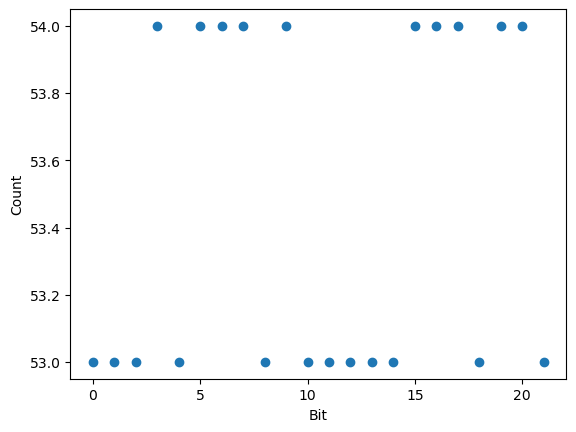

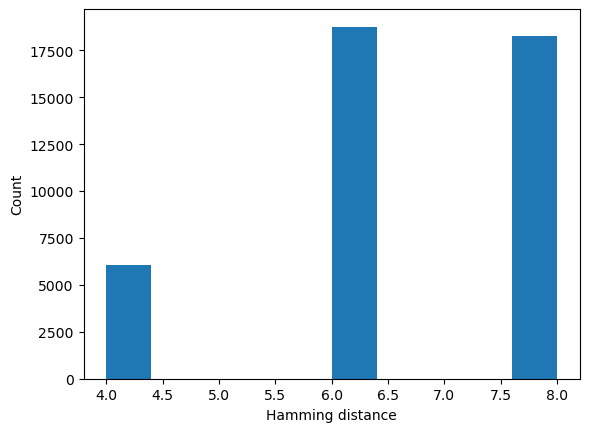

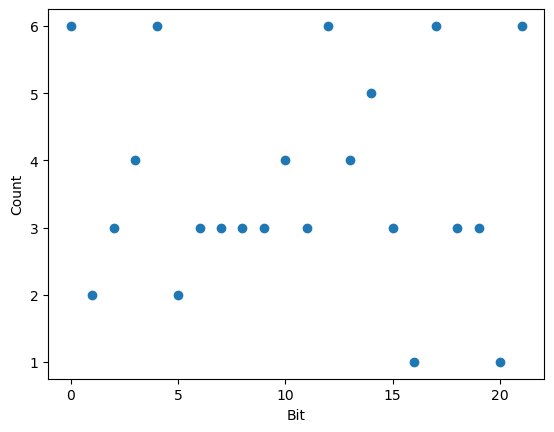

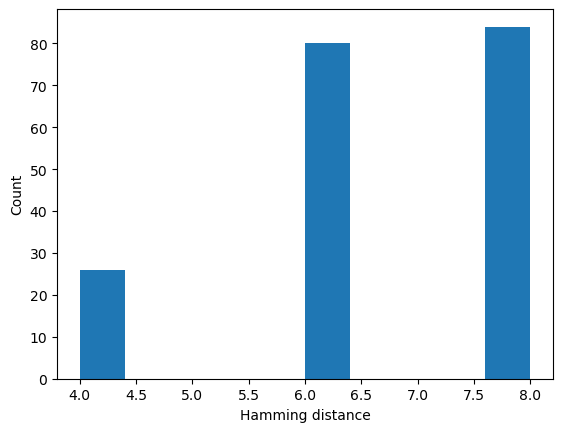

In [54]:
# Plot distributions of gene codes
hamming_code_analysis.plot_bit_coverage(gene_codes, code_length)
hamming_code_analysis.plot_pairwise_hamming_distance_distribution(gene_codes)
# Plot distributions of blank codes
hamming_code_analysis.plot_bit_coverage(blank_codes, code_length)
hamming_code_analysis.plot_pairwise_hamming_distance_distribution(blank_codes)

# Assign genes to bits

In [66]:
# Load the gene expressions for each cell cluster.
# This is a matrix of shape N_clusters x N_genes_of_interest.
# Each element is the expression level of a gene in a cluster.
cluster_gene_exp = mean_exp_df.values.transpose()
# Normalize the expressions, such that the sum of all expressions are N_clusters.
# The normalization is important for the subsequent simulated annealing.
cluster_gene_exp_normalized = cluster_gene_exp / np.sum(cluster_gene_exp) * cluster_gene_exp.shape[0]

In [75]:
# Load the cluster sizes
cluster_sizes = celltype_num['annotation'].values
# Log normalize the cluster sizes
cluster_sizes_log_normalized = np.log(cluster_sizes + 1) / np.sum(np.log(cluster_sizes + 1))

In [76]:
# Convert the gene codes to binary codes
gene_binary_codes = np.array([cds.on_bits_to_binary_code(c, code_length) for c in gene_codes])

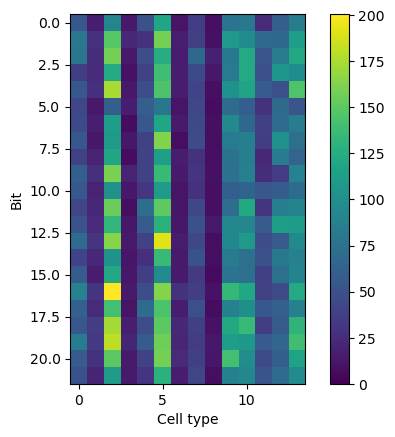

In [79]:
# Plot the distribution of numbers of bright dots in cells before optimization
# The values have the unit dot per million transcripts
cds.plot_dot_distribution(cluster_gene_exp, gene_binary_codes)

In [80]:
%%time
# Optimize the code assigment to let cells have evenly distributed dots for each bit
# Use the log of cluster sizes to weight the divergence which we want to minimize
best_score, best_codes = cds.optimize_bit_assignments_simulated_annealing_parallel(
    cluster_gene_exp_normalized, cluster_sizes_log_normalized, gene_binary_codes,
    N_test=64, N_threads=16, N_rounds=5, N_iter=20000)

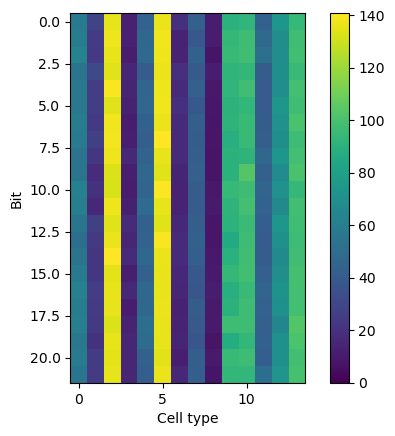

,cell_type_weights
0,0.084272
1,0.082869
2,0.077830
3,0.076799
4,0.076436
5,0.075637
6,0.072523
7,0.072302
8,0.069655
9,0.069518


In [81]:
# The dot distribution is better now.
# There are vertical strip patterns that our optimization didn't change. 
# This is because we can only optimize the distribution across bits.
# The total number of bright dots for each cell type is always 4 x N_expressed_transcripts.
cds.plot_dot_distribution(cluster_gene_exp, best_codes)

# Note that dots in some of the cell types with few cells are not very evenly distributed
pd.DataFrame({'cell_type_weights': cluster_sizes_log_normalized})

# load readouts

In [10]:

from ChromAn.src.library_tools.primers import load_fasta_to_DataFrame

readout_folder = r'/lab/solexa_weissman/puzheng/References/Readouts'
readout_filename = os.path.join(readout_folder, 'updated_Stvs.fasta')
print(f"Loading readouts from file: {readout_filename}")
readouts_all = load_fasta_to_DataFrame(readout_filename)
# select
start_bit = 0
readouts = readouts_all[start_bit:start_bit+num_bits]
readouts.loc[:, 'Name'] = np.array([_n.split(' ')[0] for _n in readouts['Name']])
#print(readouts)
readouts_names = list(readouts['Name'])

Loading readouts from file: /lab/solexa_weissman/puzheng/References/Readouts/updated_Stvs.fasta


/tmp/ipykernel_3607995/1151379484.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readouts.loc[:, 'Name'] = np.array([_n.split(' ')[0] for _n in readouts['Name']])


## Save readout file

In [12]:
# save readouts
readout_savefile = os.path.join(library_folder, 'new_readouts.csv')
print(f"Saving readouts to file: {readout_savefile}")
readouts.to_csv(readout_savefile, index=None)

Saving readouts to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/new_readouts.csv


## Save codebook

In [14]:
# Update
import MERFISH_probe_design.IO.file_io as fio
codebook = fio.load_merlin_codebook(codebook_file)


0         Mmp25
1         Ms4a1
2         Il17f
3          Il22
4         Tanc2
         ...   
309    Blank-16
310    Blank-17
311    Blank-18
312    Blank-19
313    Blank-20
Name: name, Length: 314, dtype: object

In [128]:
# Get a list of gene names including the blank barcodes
gene_names = list(mean_exp_df.index.values) + [f'Blank-{i + 1}' for i in range(N_blank)]

# Get a list of transcript names including the blank barcodes
transcript_names = [f'' for i in range(len(gene_names))]


# Convert the barcodes into strings of '1' and '0'.
barcode_binarys = [cds.on_bits_to_binary_code(c, code_length) for c in blank_codes] + list(best_codes)
barcode_strings  = [''.join([str(b) for b in c]) for c in barcode_binarys]

# Write the codebook
print(f"Saving codebook to file: {codebook_file}")
fio.write_merlin_codebook(codebook_file, '1.0', 'MsImmune', readouts_names, 
                          gene_names, transcript_names, barcode_strings)

Saving codebook to file: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\codebook.csv


In [11]:
# Update
import MERFISH_probe_design.IO.file_io as fio
codebook = fio.load_merlin_codebook(codebook_file)


In [23]:
designed_probes = pd.read_csv(os.path.join(library_folder, 'designed_probes.csv'))

replace_dict = {'Tcrg-C1':'Trgc1', 'Tcrg-C2':'Trgc2', 'Tcrg-C4':'Trgc4', 'Sept1':'Septin1', 'H2afy':'Macroh2a2','Qk':'Qki'}

In [21]:
#gene_names = [_g for _g in codebook[3]['name'] if 'Blank-' not in _g]

In [24]:
gene_names = codebook[3]['name']
cured_gene_names = []
for _g in gene_names:
    if _g in replace_dict:
        cured_gene_names.append(replace_dict[_g])
    else:
        cured_gene_names.append(_g)

In [46]:
gene_2_transcript = {}
for _i, (_g, _t) in designed_probes[['gene_id','transcript_id']].iterrows():
    if _g not in gene_2_transcript:
        gene_2_transcript[_g] = _t


In [47]:
gene_2_transcript

{'Igkc': 'ENSMUST00000103410.3',
 'Iglc2': 'ENSMUST00000103749.3',
 'Il21': 'ENSMUST00000029273.8',
 'Xcl1': 'ENSMUST00000027860.8',
 'S100a10': 'ENSMUST00000148400.2',
 'Slpi': 'ENSMUST00000109367.10',
 'Fscn1': 'ENSMUST00000031565.15',
 'Trgc4': 'ENSMUST00000179181.3',
 'Ly6i': 'ENSMUST00000023250.11',
 'H2-DMa': 'ENSMUST00000042121.11',
 'Cytip': 'ENSMUST00000028175.7',
 'Csf2': 'ENSMUST00000019060.6',
 'Csf1r': 'ENSMUST00000025523.13',
 'Il17a': 'ENSMUST00000027061.5',
 'Fcgr1': 'ENSMUST00000029748.8',
 'Cd80': 'ENSMUST00000231716.2',
 'Adgre4': 'ENSMUST00000025004.7',
 'Cd79a': 'ENSMUST00000003469.8',
 'Ms4a1': 'ENSMUST00000169159.3',
 'Itgae': 'ENSMUST00000102537.10',
 'Plbd1': 'ENSMUST00000032336.7',
 'Slfn4': 'ENSMUST00000000208.13',
 'Irf8': 'ENSMUST00000047737.10',
 'Pld4': 'ENSMUST00000063888.5',
 'Treml4': 'ENSMUST00000059873.14',
 'Ccr7': 'ENSMUST00000103134.4',
 'Fbxl5': 'ENSMUST00000196483.5',
 'Plekhm3': 'ENSMUST00000097713.2',
 'Zfand5': 'ENSMUST00000237651.2',
 'Anxa5

In [48]:
N_blank = len([_g for _g in codebook[3]['name'] if 'Blank-' in _g])
print(N_blank)
blank_codes = codebook[3]['barcode_str'][:N_blank]
best_codes = codebook[3]['barcode_str'][N_blank:]

20


In [ ]:
mean_exp_df.re

In [50]:
'Tcrg-C1' in gene_2_transcript

False

In [55]:
best_codes

20     0000000000000101001010
21     0000000100000100110000
22     0100100000000001001000
23     1000000000000100011000
24     1100000000000100000100
                ...          
309    0000010010010000001000
310    1101000000000000000001
311    1100000011000000000000
312    0000000100011000100000
313    0000010100000000101000
Name: barcode_str, Length: 294, dtype: object

In [56]:
# Get a list of gene names including the blank barcodes
gene_names = list(mean_exp_df.index.values) + [f'Blank-{i + 1}' for i in range(N_blank)]

# Get a list of transcript names including the blank barcodes
transcript_names = [gene_2_transcript[_g] for _g in list(mean_exp_df.index.values)] + ["" for _i in range(N_blank)]

#barcode copy from old, after resorting:
barcode_strings  = list(best_codes) + list(blank_codes)

# Readtouts: copy
readout_names = codebook[2]

In [58]:
# codebook_savefile:
new_codebook_savefile = os.path.join(library_folder, 'full_codebook.csv')
# Write the codebook
print(f"Saving updated codebook to file: {new_codebook_savefile}")
fio.write_merlin_codebook(new_codebook_savefile, '1.0', 'MsImmune', readout_names, 
                          gene_names, transcript_names, barcode_strings)

Saving updated codebook to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/full_codebook.csv
